# Enet using deconvo genes from Bayes Prism (mirroring feature engineering as closely as possible to original paper)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split

from scipy.stats import pearsonr
# from numpy.polynomial.polynomial import Polynomial

## Data Filtering

In [17]:
# metadata
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx', index_col=0)

# rnaseq versions
fpkm = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
tpm = pd.read_csv('../data/tpm.csv', index_col=0, low_memory=False)



In [18]:
# ann_tcga[ann_tcga['event.PALB2'].ne('0')]
# ann_tcga[ann_tcga['event.RAD51C'].ne('0')]
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')
metadata.shape

(889, 34)

In [32]:
fpkm = fpkm.set_index('Case ID')
# fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])
fpkm.index = fpkm.index.map(lambda x: x[:12])
print(f"rna-seq shape{fpkm.shape}")

deconvo.index = deconvo.index.map(lambda x: x[:12])

dick = {}
for i, v in enumerate(fpkm.columns):
    # print(i,v)
    dick[v.split('|')[0]] =v.split('|')[1]
tpm = tpm.rename(columns=dick)
tpm.index = tpm.index.map(lambda x: x[:12])


fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
# deconvo = deconvo.sort_index()
# deconvo = np.log2(deconvo + 1)
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
deconvo = deconvo.loc[deconvo.index.intersection(metadata.index)]
deconvo.sort_index(inplace=True)
tpm = tpm.loc[tpm.index.intersection(metadata.index)]
tpm.sort_index(inplace=True)

print(f"fpkm shape{fpkm.shape}")
print(f"deconvo shape{deconvo.shape}")
print(f"tpm shape{tpm.shape}")


rna-seq shape(1231, 60660)


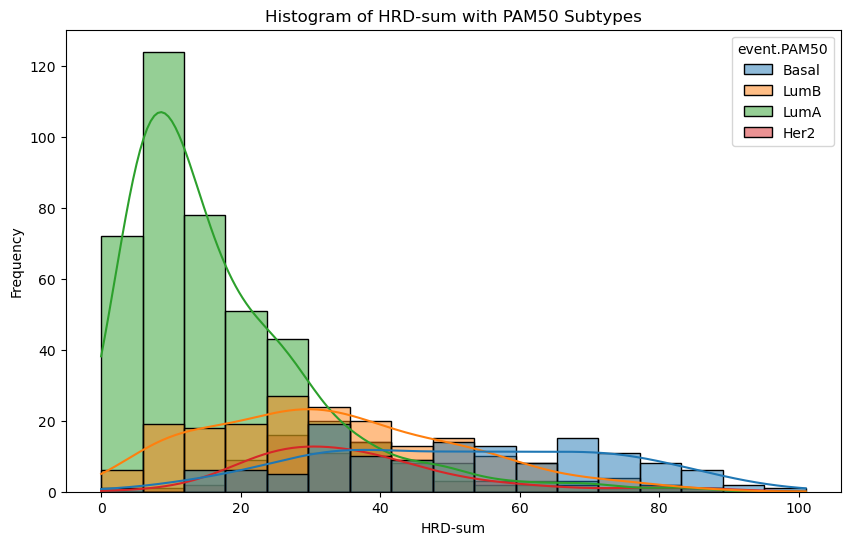

event.PAM50
LumA     430
LumB     188
Basal    134
Her2      73
Name: count, dtype: int64


In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data=metadata, x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
plt.title('Histogram of HRD-sum with PAM50 Subtypes')
plt.xlabel('HRD-sum')
plt.ylabel('Frequency')
plt.show()
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)

In [8]:

def downsampling_lumA(metadata, lumA_cutoff):
    lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
    lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
    # print(lumA_HRP.shape, lumA_HRD.shape)
    lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
    df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
    df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])
    print(df_downsampled['event.PAM50'].value_counts())
    print(df_downsampled.shape)
    unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
    return df_downsampled, unused_majority

# df_downsampled, removed_samples = downsampling_lumA(metadata, 23)

def add_back_test(rna_df, removed_samples, X_test,y_test):
    add_back_features = rna_df.loc[rna_df.index.intersection(removed_samples.index)]
    add_back_features = add_back_features.sort_index()

    add_back_y = removed_samples.loc[removed_samples.index.intersection(rna_df.index)]
    add_back_y = add_back_y.sort_index()

    X_test = pd.concat([X_test, add_back_features])
    y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])
    return X_test, y_test

# X_test,y_test = add_back_test(deconvo, removed_samples, X_test, y_test)

def sigmoid_transform(values, shift=0, scale=1):
    return 1 / (1 + np.exp(-scale * (values - shift)))
def binary_hrd(values, threshold):
    return (values >= threshold).astype(int)

def plot_test_train_pam50_dist(metadata, X_train, X_test):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)], x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Test Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)], x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Train Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    # pam50_counts = df_downsampled['event.PAM50'].value_counts()
    # print(pam50_counts)
    # print(df_downsampled.shape)
# plot_test_train_pam50_dist(metadata, X_train, X_test)

event.PAM50
LumA     228
LumB     188
Basal    134
Her2      73
Name: count, dtype: int64
(635, 34)


## Regression: Takes 250 hrs 6-cpu

{'alpha': 0.01, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.628e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.643e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.998e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.715e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.361e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.9}


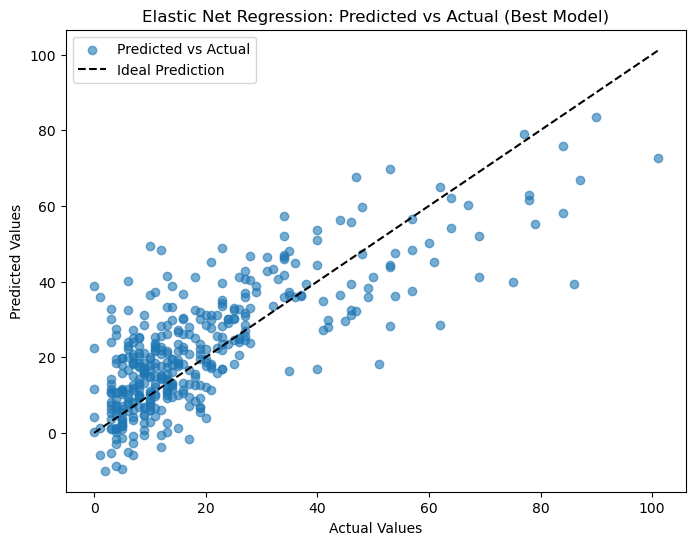

Best Parameters: {'alpha': 1.0, 'l1_ratio': 0.1}
Mean Squared Error: 142.081
R^2 Score: 0.561


In [17]:
from sklearn.model_selection import ParameterSampler

alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.7, 0.9]
rna_seqs = [deconvo, tpm, fpkm]
downsample = [(True, False),(True,False), (False,False)]
downsample_thresholds = [x for x in range(10, 80, 5)]
softlabels = ["None", "Sigmoid", "Binary"]
softlabel_thresholds = [x for x in range(10, 80, 5)]
softlabel_gradients = np.arange(0, 1, 0.1)
normalization = ['StandardScaler','log2','None']


best_model = None
best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
best_params = {}

# Grid search
param_distributions = {'alpha': alphas, 'l1_ratio': l1_ratios,
                            'rna-seq': rna_seqs, 'downsample': downsample,
                            'downsample_thresholds': downsample_thresholds,'softlabels': softlabels,
                            'softlabel_thresholds': softlabel_thresholds, 'softlabel_gradients': softlabel_gradients,
                            'normalization': normalization}


n_iter = 100  # You can adjust this value based on your computational resources

# Generate random combinations of parameters
random_params = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))


for params in random_params:
    print(params)
    # Split data into training and test sets and get intersecting indices
    features_df = params['rna-seq']
    features_df = features_df.loc[features_df.index.intersection(metadata.index)]
    metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
    labels_df = metadata_truncated['HRD-sum']
    labels_df = labels_df.sort_index()
    features_df = features_df.sort_index()
    
    if params['normalization'] == 'StandardScaler':
        scaler = StandardScaler()
        features_df = pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns)
    elif params['normalization'] == 'log2':
        features_df = np.log2(features_df + 1)
    
    # Apply soft labels
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel'])
    labels = labels_df.squeeze()
    

    # Downsample LumA samples
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df = features_df.loc[features_df.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df.index), 'HRD-sum']
        
    #TEST TRAIN SPLIT
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
    
    if params['downsample'][1]:
        X_test,y_test = add_back_test(features_df, removed_samples, X_test, y_test)
        
    
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Update best model if current is better
    # if mse < best_metrics['Mean Squared Error']:
    if mse < best_metrics['Mean Squared Error'] or (mse == best_metrics['Mean Squared Error'] and r2 > best_metrics['R^2 Score']):
        best_model = model
        best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
        best_params = params
        best_X_train = X_train
        best_X_test = X_test

# Scatter plot of predictions vs actual values for the best model
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
plt.legend(loc="upper left")
plt.show()
plot_test_train_pam50_dist(metadata, best_X_train, best_X_test)
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")

# return best_model, best_metrics, best_params
elastic_model = best_model
metrics = best_metrics
params = best_params
# Main Execution with Hyperparameter Grid Search




# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# Define hyperparameter ranges


# elastic_model, metrics, params = train_evaluate_elastic_net_with_grid_search(
#     X_train, X_test, y_train, y_test, alphas, l1_ratios
# )





In [18]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]
breast_filt = genes_validation_transposed_sorted[genes_validation_transposed_sorted.index.str.contains('BREAST')]
breast_filt

Description,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
AU565_BREAST,32.0,1231.0,3.0,1.0,0.0,0.0,3.0,4.0,152.0,2582.0,...,1146916.0,6.0,3.0,8.0,389708.0,146916.0,24.0,364079.0,2.0,7.0
BT20_BREAST,21.0,853.0,2.0,0.0,1.0,3.0,4.0,10.0,141.0,3214.0,...,1643737.0,7.0,3.0,7.0,558184.0,182410.0,48.0,745031.0,1.0,6.0
BT474_BREAST,3.0,911.0,5.0,9.0,2.0,3.0,6.0,3.0,58.0,187.0,...,1169056.0,8.0,9.0,22.0,522991.0,165302.0,44.0,733933.0,10.0,3.0
BT483_BREAST,19.0,1306.0,5.0,4.0,7.0,4.0,15.0,12.0,69.0,33.0,...,1547088.0,11.0,9.0,9.0,798460.0,320052.0,45.0,1245412.0,3.0,35.0
BT549_BREAST,14.0,1214.0,8.0,11.0,6.0,3.0,7.0,11.0,42.0,57.0,...,1039147.0,12.0,4.0,16.0,513498.0,160632.0,16.0,644871.0,2.0,6.0
CAL120_BREAST,7.0,630.0,3.0,1.0,5.0,0.0,3.0,2.0,26.0,31.0,...,550124.0,9.0,3.0,6.0,281034.0,83378.0,20.0,229436.0,4.0,7.0
CAL148_BREAST,10.0,1949.0,6.0,5.0,5.0,6.0,10.0,27.0,257.0,1494.0,...,1422127.0,7.0,6.0,9.0,607899.0,212433.0,31.0,1044307.0,8.0,39.0
CAL51_BREAST,2.0,1237.0,2.0,3.0,2.0,1.0,5.0,3.0,30.0,221.0,...,785289.0,5.0,7.0,8.0,410039.0,141330.0,18.0,413946.0,4.0,8.0
CAL851_BREAST,51.0,988.0,10.0,21.0,12.0,8.0,33.0,8.0,113.0,272.0,...,4067011.0,47.0,14.0,3108.0,1621072.0,570312.0,496.0,2169530.0,14.0,95.0
CAMA1_BREAST,13.0,1312.0,11.0,6.0,6.0,7.0,9.0,17.0,99.0,59.0,...,2304663.0,17.0,17.0,1286.0,879298.0,255524.0,66.0,1431185.0,84.0,8.0


In [19]:
breast_filt = np.log2(breast_filt+1)
breast_filt.index = breast_filt.index.str.split('_').str[0]
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deconvo.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deconvo.columns))

feature_columns = breast_filt_aligned.columns  # Adjust if necessary
X = breast_filt_aligned[feature_columns]

# Generate predictions
predictions = elastic_model.predict(X)

# Add the predictions to the DataFrame
breast_filt_aligned['Predictions'] = predictions
predictions

Are columns aligned? True


array([52.34750613, 49.81406144, 48.96917918, 46.75017353, 36.79760376,
       24.77641117, 29.96415661, 37.37733398, 81.45730974, 35.57359082,
       16.96078677, 54.64315151, 57.14560992, 74.35519296, 60.70103868,
       49.442298  , 39.31727288, 76.21554181, 55.99355061, 55.69818993,
       55.62216232, 66.8396077 , 67.26457697, 57.34375993, 72.96726149,
       28.44132531, 48.8333085 , 72.91562194, 60.36465127, 69.6775705 ,
       41.98432321, 43.81110071, 50.7150939 , 64.25346959, 40.15694343,
       37.88904855, 26.95522153, 51.06455169, 25.32968558, 24.6936104 ,
       62.30978586, 37.59211198, 51.74965978, 38.99935956, 48.07337442,
       49.04817537, 51.37418477, 36.22172527, 62.60762556, 34.33468195,
       44.96580797])

In [20]:
# Load the data
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

# Define PARP inhibitors
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']

# Filter and select specific drugs
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']].copy()

# Apply transformations explicitly
parpi_resp_filt['IC50'] = parpi_resp_filt['IC50'].clip(lower=1e-6)
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])

parpi_resp_filt["Cell Line Name"] = parpi_resp_filt["Cell Line Name"].str.replace("-", "", regex=True)

merged_df = breast_filt_aligned.merge(
    parpi_resp_filt,
    right_on ='Cell Line Name',
    left_index=True
)
subset_df = merged_df[['Cell Line Name', 'Drug Name', 'Predictions', 'log10IC50']]
subset_df

,Cell Line Name,Drug Name,Predictions,log10IC50
31,AU565,Olaparib,52.347506,0.649300
81,AU565,Veliparib,52.347506,0.728449
275,AU565,Rucaparib,52.347506,0.618083
323,AU565,Niraparib,52.347506,0.658753
370,AU565,Talazoparib,52.347506,0.446904
...,...,...,...,...
30,ZR7530,Olaparib,44.965808,0.774099
80,ZR7530,Veliparib,44.965808,0.791624
274,ZR7530,Rucaparib,44.965808,0.785756
322,ZR7530,Niraparib,44.965808,0.690543


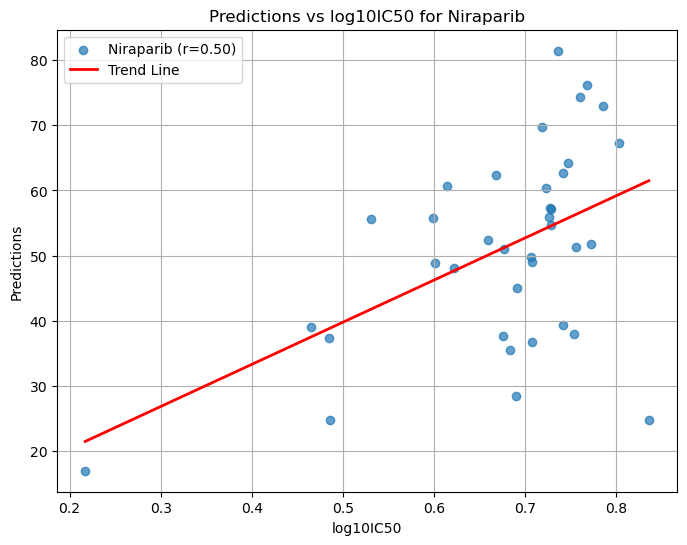

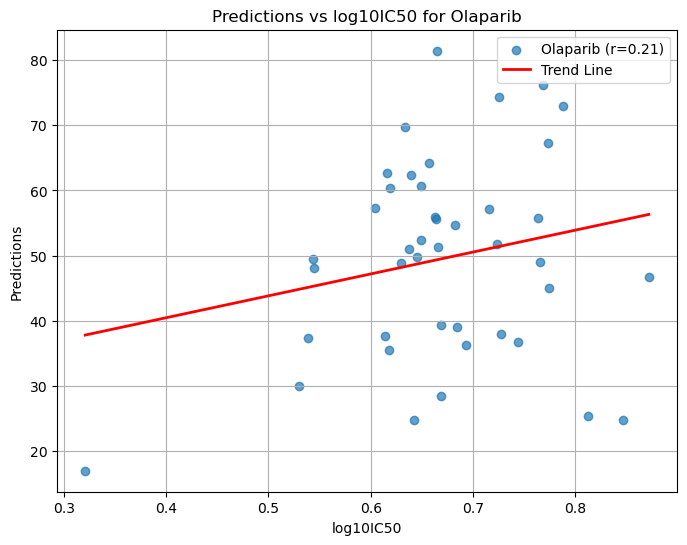

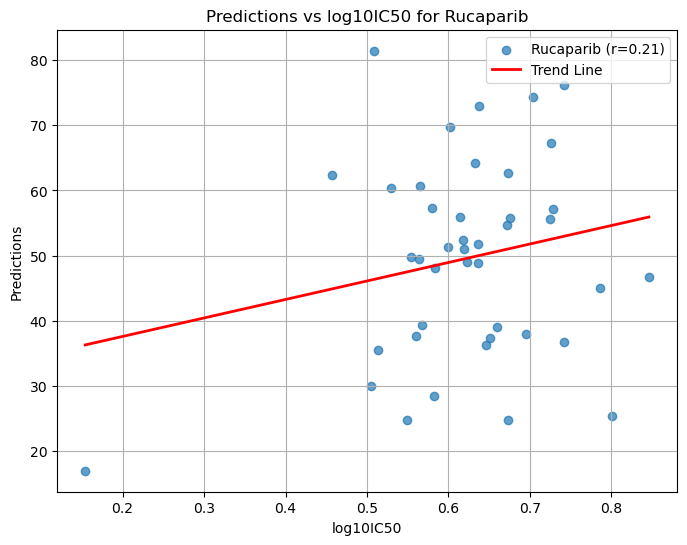

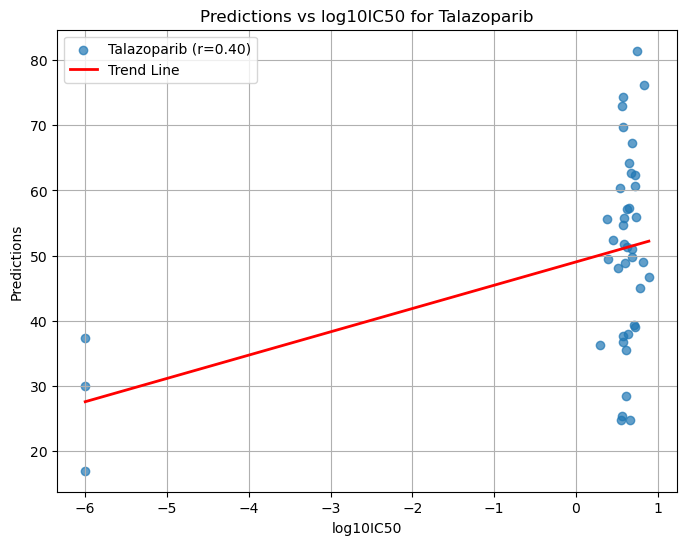

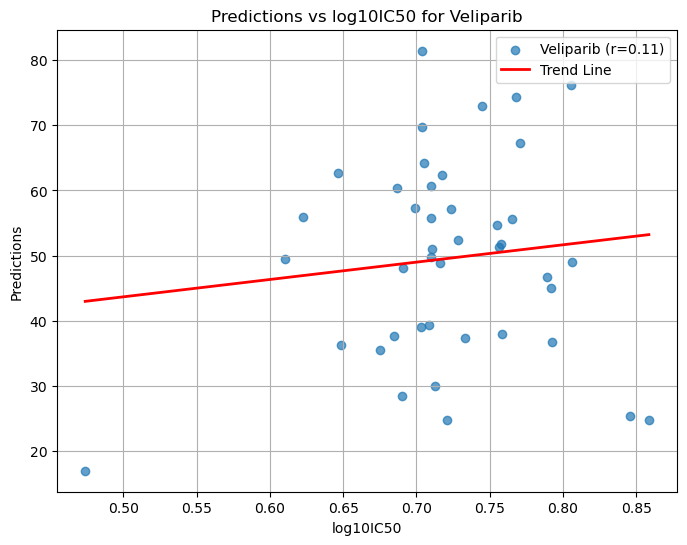

Niraparib: Correlation Coefficient = 0.50, P-Value = 0.0017
Olaparib: Correlation Coefficient = 0.21, P-Value = 0.1748
Rucaparib: Correlation Coefficient = 0.21, P-Value = 0.1847
Talazoparib: Correlation Coefficient = 0.40, P-Value = 0.0078
Veliparib: Correlation Coefficient = 0.11, P-Value = 0.4688


In [21]:


# Group the DataFrame by 'Drug Name'
grouped = merged_df.groupby('Drug Name')

# Initialize a dictionary to store correlation coefficients
correlation_results = {}

# Loop through each group and create a plot
for drug_name, group in grouped:
    # Calculate Pearson correlation coefficient
    corr_coef, p_value = pearsonr(group['log10IC50'], group['Predictions'])
    correlation_results[drug_name] = {
        'Correlation Coefficient': corr_coef,
        'P-Value': p_value
    }
    
    # Fit a linear trend line
    poly = Polynomial.fit(group['log10IC50'], group['Predictions'], deg=1)
    x_line = np.linspace(group['log10IC50'].min(), group['log10IC50'].max(), 100)
    y_line = poly(x_line)

    # Plot the scatter plot with trend line
    plt.figure(figsize=(8, 6))
    plt.scatter(group['log10IC50'], group['Predictions'], label=f'{drug_name} (r={corr_coef:.2f})', alpha=0.7)
    plt.plot(x_line, y_line, color='red', label='Trend Line', linewidth=2)
    plt.title(f'Predictions vs log10IC50 for {drug_name}')
    plt.xlabel('log10IC50')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    plt.show()

# Display correlation results
for drug, stats in correlation_results.items():
    print(f"{drug}: Correlation Coefficient = {stats['Correlation Coefficient']:.2f}, P-Value = {stats['P-Value']:.4f}")


In [22]:
# Step 1: Extract coefficients
coefficients = elastic_model.coef_

# Step 2: Calculate the absolute values of the coefficients
absolute_coefficients = np.abs(coefficients)

# Step 3: Get the indices of the top 300 coefficients
top_300_indices = np.argsort(absolute_coefficients)[-100:]  # Get indices of the largest 300 coefficients

# Step 4: Retrieve the corresponding column names from `deconvo`
top_300_genes = deconvo.columns[top_300_indices]

# Display the top genes
print(f"Top 300 genes associated with the model: {top_300_genes}")
top_genes = list(top_300_genes)


Top 300 genes associated with the model: Index(['ERBB4', 'IGF1R', 'RHOU', 'NXPH4', 'MUC20', 'B4GALNT4', 'CEBPD',
       'PPP1R1B', 'CD163L1', 'ELF5', 'GRB14', 'ARIH2OS', 'CSPG4', 'VSTM2A',
       'TFF1', 'C17orf58', 'SCNN1A', 'GBP5', 'DAPP1', 'SYBU', 'TMEM98',
       'MPV17L', 'C20orf96', 'ATAD3C', 'CLDN3', 'ZNF626', 'NOVA1', 'RPP21',
       'KLHL23', 'CDH7', 'QPRT', 'HLA-G', 'DSCR8', 'C1QB', 'ACTG2', 'ZBTB16',
       'GSTM1', 'VWA5A', 'IL20', 'PHYHD1', 'FAM3B', 'PTP4A1', 'REEP6',
       'EFCAB1', 'CHADL', 'ERP27', 'ZBTB18', 'CRACR2B', 'SDR42E1', 'NBPF15',
       'CLN3', 'CACNA1D', 'COL10A1', 'KRT17', 'SCRN1', 'CAPN12', 'GDF15',
       'PITX1', 'CDCA7L', 'FAM27C', 'TLX1', 'IDH2', 'CEACAM6', 'ID4',
       'ANKRD35', 'TFRC', 'CLDN4', 'ST8SIA1', 'MT1E', 'MLF1', 'TBX1', 'GSTT2B',
       'TFF3', 'CYP51A1', 'ELL3', 'SLC12A2', 'SPA17', 'BARX2', 'SFN', 'IZUMO4',
       'ATF7IP2', 'GNA14', 'ANO9', 'PEX11A', 'ECHDC3', 'MIA', 'ZNF804B',
       'MST1R', 'MISP', 'OVOL1', 'LMX1B', 'NAT1', 'AREG', 'T

In [23]:

actual228 = ['MXRA8',
'PRKCZ',
'MEGF6',
'FBXO2',
'UBXN10',
'SYTL1',
'CITED4',
'C1orf210',
'GPX7',
'GBP4',
'VAV3',
'MLLT11',
'ATP1A4',
'KLHDC9',
'RABGAP1L',
'FMOD',
'RAB29',
'ZBTB18',
'SH3YL1',
'ATP6V1E2',
'UBE2E3',
'FRZB',
'PPIL3',
'PECR',
'TMEM198',
'STK11IP',
'IRS1',
'KIF1A',
'NUP210',
'ALS2CL',
'IP6K2',
'DALRD3',
'APEH',
'CACNA1D',
'FHIT',
'MTRNR2L12',
'COPG1',
'DHX36',
'USP13',
'MAGEF1',
'SENP2',
'ZNF718',
'AREG',
'SLC7A11',
'MAP9',
'SORBS2',
'FRG1',
'NADK2',
'FAM174A',
'DTWD2',
'PCDHB4',
'PCDH1',
'THOC3',
'SIMC1',
'F12',
'FAM135A',
'OGFRL1',
'CD109',
'RRAGD',
'WASF1',
'ACAT2',
'SNX10',
'SCRN1',
'NCF1',
'TMEM120A',
'AZGP1',
'SMKR1',
'PODXL',
'AKR1B1',
'TMEM139',
'SPIDR',
'TPD52',
'CA13',
'ATP6V1C1',
'BAALC',
'AARD',
'EXT1',
'SAMD12',
'MAL2',
'TAF2',
'MTBP',
'ZHX1',
'FBXO32',
'SQLE',
'LRRC6',
'VLDLR',
'SIGMAR1',
'ALDH1B1',
'CKS2',
'SYK',
'PHYHD1',
'PTGES',
'BET1L',
'RIC8A',
'SIRT3',
'RNH1',
'LRRC56',
'IRF7',
'PNPLA2',
'CRACR2B',
'ASCL2',
'TSSC4',
'PPFIBP2',
'CTR9',
'CD44',
'TCN1',
'FADS2',
'ME3',
'DCUN1D5',
'CLMP',
'SPA17',
'TMEM218',
'FOXRED1',
'GLB1L2',
'ANKRD30A',
'PDCD4',
'TACC2',
'TEAD4',
'LAG3',
'ZNF605',
'ZNF10',
'BRCA2',
'N4BP2L2',
'EXOSC8',
'COG3',
'PHF11',
'EBPL',
'IPO5',
'TEX30',
'IRS2',
'CARS2',
'ING1',
'TFDP1',
'GSC',
'SLC25A29',
'JAG2',
'RASL12',
'LARP6',
'ZNF592',
'AEN',
'ACAN',
'HAPLN3',
'MFGE8',
'FANCI',
'POLG',
'ANPEP',
'ARPIN',
'GDPGP1',
'NGRN',
'HDDC3',
'UNC45A',
'RCCD1',
'PRC1',
'ASB7',
'SNRPA1',
'IL32',
'BOLA2B',
'IRX6',
'MT1G',
'PLEKHG4',
'C16orf95',
'GALNS',
'CBFA2T3',
'CPNE7',
'YWHAE',
'INPP5K',
'GABARAP',
'KDM6B',
'ZSWIM7',
'TTC19',
'LYRM9',
'UNC119',
'NEK8',
'TRAF4',
'PGAP3',
'JUP',
'ACLY',
'NKIRAS2',
'BRCA1',
'TMUB2',
'EFTUD2',
'FMNL1',
'PRR15L',
'DCAF7',
'TACO1',
'LRRC37A3',
'SLC39A11',
'ARMC7',
'MIF4GD',
'WBP2',
'EVPL',
'SEC14L1',
'TK1',
'SOCS3',
'CANT1',
'CARD14',
'RPTOR',
'ALYREF',
'FOXK2',
'FN3KRP',
'FN3K',
'TMEM241',
'MOCOS',
'NFATC1',
'C20orf96',
'RBCK1',
'FAM110A',
'SLC4A11',
'DZANK1',
'CD40',
'SLC25A23',
'LRRC8E',
'FXYD5',
'SYNE4',
'BCKDHA',
'CNFN',
'CXCL17',
'PVR',
'ZNF583',
'ZNF419',
'TMEM191B',
'TOP3B',
'PRAME',
'PLA2G6',
'NPTXR',
'ODF3B',
'PCP4',
'RSPH1']

In [24]:
print(set(top_genes) & set(actual228))
print(len(set(top_genes) & set(actual228)))

{'PHYHD1', 'AREG', 'C20orf96', 'BRCA1', 'CACNA1D', 'SPA17', 'SCRN1', 'ZBTB18', 'CRACR2B'}
9


In [25]:
print(len(top_genes))

100


In [26]:
for i in top_genes:
    if i[0] == 'B':
        print(i)

B4GALNT4
BARX2
BRCA1
